[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/repos-especializacion-UdeA/monografia_modelos/blob/main/05_models_cluster.ipynb)

# Modelos a partir de las caracteristicas RMS

In [3]:
try:
    import google.colab 
    !wget --no-cache -O init.py -q https://raw.githubusercontent.com/repos-especializacion-UdeA/monografia_modelos/refs/heads/main/init.py
    from init import init; init(force_download=False)
except ImportError:
    print("Ejecucion del notebook en entorno local")

Ejecucion del notebook en entorno local


## Objetivo a desarrollar

* Obtener diferentes modelos usando la caracteristica RMS

## Actividades

To Do...

## 1. Librerias y configuraciones previas

In [1]:
# Verificacion de librerias necesarias antes de empezar
try:
    import scipy.io
    print("La librería 'scipy' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'scipy' no está instalada.")
    print("Instalando 'scipy'...")
    !pip install scipy

try:
    import libemg
    print("La librería 'libEMG' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'libEMG' no está instalada.")
    print("Instalando 'libEMG'...")
    !pip install libemg

try:
    import imblearn
    print("La librería 'imblearn' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'imblearn' no está instalada.")
    print("Instalando 'imblearn'...")
    !pip install imblearn

try:
    import umap
    print("La librería 'umap-learn' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'umap-learn' no está instalada.")
    print("Instalando 'umap-learn'...")
    !pip install umap-learn

La librería 'scipy' está instalada y se ha importado correctamente.
La librería 'libEMG' está instalada y se ha importado correctamente.
La librería 'imblearn' está instalada y se ha importado correctamente.
La librería 'umap-learn' está instalada y se ha importado correctamente.


In [2]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib


# Gestion de librerias
# ==============================================================================
from importlib import reload

# Matemáticas y estadísticas
# ==============================================================================
import math

# Preparación de datos
# ==============================================================================
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import LocalOutlierFactor
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Formateo y estilo
# ==============================================================================
from IPython.display import Markdown, display

# Biblioteca scipy y componentes
# ==============================================================================
import scipy.io
from scipy import signal

# Bliblioteca de archivos
# ==============================================================================
import requests
from tqdm import tqdm
import os
import zipfile
import sys
import copy
import re

# Biblioteca libemg
# ==============================================================================
from libemg.data_handler import OfflineDataHandler, RegexFilter
from libemg.utils import get_windows
from libemg.feature_extractor import FeatureExtractor
from libemg import filtering

# Asumo que estas importaciones ya están en tu código:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from itertools import cycle
from sklearn.decomposition import PCA, KernelPCA
import umap

# 2. Funciones

In [4]:
def load_data_to_model_csv(directory_path):
    """
    Carga todos los archivos CSV de un directorio, identifica si son conjuntos balanceados o desbalanceados
    según el nombre del archivo, y agrupa los datos en dos diccionarios.

    Args:
        directory_path (str): Ruta al directorio que contiene archivos CSV.

    Returns:
        tuple: (dict_imbalanced, dict_balanced) donde cada diccionario contiene DataFrames indexados por un identificador extraído del nombre del archivo.
    """
    all_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
    print(f"Archivos encontrados: {all_files}")

    dict_imbalanced = {}
    dict_balanced = {}

    for file in all_files:
        file_path = os.path.join(directory_path, file)
        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error leyendo el archivo {file}: {e}")
            continue

        print(f"Archivo: {file}")

        # Se asume que el identificador está antes del primer guion bajo
        feature = file.split('_')[0]
        feature = feature.split('.')[0]  # Elimina la extensión del archivo

        # Clasifica en el diccionario correspondiente
        if 'imbalanced' in file.lower():
            dict_imbalanced[feature] = df
        else:
            dict_balanced[feature] = df

        print(f"Datos cargados para '{feature}': {df.shape[0]} filas, {df.shape[1]} columnas")

    return dict_imbalanced, dict_balanced

## 3. Variables del entorno

In [5]:
ROOT_DIR =  './'
DATA_DIR =  ROOT_DIR + 'local/data/'
if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)    
RAW_DATA_DIR = DATA_DIR + 'raw'
if not os.path.exists(RAW_DATA_DIR):
    os.makedirs(RAW_DATA_DIR)
RAW_DATA_DIR_NPY = DATA_DIR + 'raw_numpy'
if not os.path.exists(RAW_DATA_DIR_NPY):
    os.makedirs(RAW_DATA_DIR_NPY)
RAW_SUBSET_DATA_DIR = DATA_DIR + 'raw_subset'
if not os.path.exists(RAW_SUBSET_DATA_DIR):
    os.makedirs(RAW_SUBSET_DATA_DIR)
FILTERED_SUBSET_DATA_DIR = DATA_DIR + 'filtered_subset'
if not os.path.exists(FILTERED_SUBSET_DATA_DIR):
    os.makedirs(FILTERED_SUBSET_DATA_DIR)
FEATURES_SUBSET_DATA_DIR = DATA_DIR + 'features_subset'
if not os.path.exists(FEATURES_SUBSET_DATA_DIR):
    os.makedirs(FEATURES_SUBSET_DATA_DIR)
FEATURES_SUBSET_BALANCED_DATA = DATA_DIR + 'features_subset_balanced'
if not os.path.exists(FEATURES_SUBSET_BALANCED_DATA):
    os.makedirs(FEATURES_SUBSET_BALANCED_DATA)

print("Directorio de trabajo:", ROOT_DIR)
print("Directorio de datos:", DATA_DIR)
print("Directorio de datos crudos:", RAW_DATA_DIR)
print("Directorio de datos crudos (numpy):", RAW_DATA_DIR_NPY)
print("Directorio de datos crudos (subconjunto):", RAW_SUBSET_DATA_DIR)
print("Directorio de datos filtrados (subconjunto):", FILTERED_SUBSET_DATA_DIR)
print("Directorio de datos de características (subconjunto):", FEATURES_SUBSET_DATA_DIR)
print("Directorio de datos de características (subconjunto balanceado):", FEATURES_SUBSET_BALANCED_DATA)

Directorio de trabajo: ./
Directorio de datos: ./local/data/
Directorio de datos crudos: ./local/data/raw
Directorio de datos crudos (numpy): ./local/data/raw_numpy
Directorio de datos crudos (subconjunto): ./local/data/raw_subset
Directorio de datos filtrados (subconjunto): ./local/data/filtered_subset
Directorio de datos de características (subconjunto): ./local/data/features_subset
Directorio de datos de características (subconjunto balanceado): ./local/data/features_subset_balanced


In [7]:
MODELS_DIR = ROOT_DIR + 'local/models'
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)

CLASSIFICARION_MODELS_DIR = MODELS_DIR + '/classification'
if not os.path.exists(CLASSIFICARION_MODELS_DIR):
    os.makedirs(CLASSIFICARION_MODELS_DIR)

SCALERS_DIR = MODELS_DIR + '/scalers'
if not os.path.exists(SCALERS_DIR):
    os.makedirs(SCALERS_DIR)

print("Directorio de modelos:", MODELS_DIR)
print("Directorio de modelos de clasificación:", CLASSIFICARION_MODELS_DIR)
print("Directorio de escaladores:", SCALERS_DIR)

Directorio de modelos: ./local/models
Directorio de modelos de clasificación: ./local/models/classification
Directorio de escaladores: ./local/models/scalers


## 4. Carga del dataset de las caracteristicas

Carga y combinación de los datos en un solo dataframe

In [8]:
FEATURES_SUBSET_BALANCED_DATA

'./local/data/features_subset_balanced'

El dataframe en el que se combinaron los datos fue: `merged_df` 

In [9]:
# Load and merge CSV files
dict_imbalanced, dict_balanced = load_data_to_model_csv(FEATURES_SUBSET_BALANCED_DATA)

Archivos encontrados: ['IAV_balanced.csv', 'IAV_imbalanced.csv', 'RMS_balanced.csv', 'RMS_imbalanced.csv', 'WL_balanced.csv', 'WL_imbalanced.csv']
Archivo: IAV_balanced.csv
Datos cargados para 'IAV': 13272 filas, 11 columnas
Archivo: IAV_imbalanced.csv
Datos cargados para 'IAV': 21594 filas, 14 columnas
Archivo: RMS_balanced.csv
Datos cargados para 'RMS': 13272 filas, 11 columnas
Archivo: RMS_imbalanced.csv
Datos cargados para 'RMS': 21594 filas, 14 columnas
Archivo: WL_balanced.csv
Datos cargados para 'WL': 13272 filas, 11 columnas
Archivo: WL_imbalanced.csv
Datos cargados para 'WL': 21594 filas, 14 columnas


En los diccionarios `dict_imbalanced`, `dict_balanced` estan las caracteristicas de las señales capturadas para cada usuario. El diccionario `dict_imbalanced` se usara luego para realizar un clustering para clasificación usando kmeans.

In [10]:
dict_imbalanced.keys()

dict_keys(['IAV', 'RMS', 'WL'])

In [11]:
for feature_name, df in dict_imbalanced.items():
    print(f"{feature_name}: {df.shape}")

IAV: (21594, 14)
RMS: (21594, 14)
WL: (21594, 14)


In [12]:
for feature_name, df in dict_balanced.items():
    print(f"{feature_name}: {df.shape}")

IAV: (13272, 11)
RMS: (13272, 11)
WL: (13272, 11)


In [14]:
# Display the first few rows of the first DataFrame
df_rms_imbalanced = dict_imbalanced['RMS'].copy()
df_rms_imbalanced.head()

,RMS_ch1,RMS_ch2,RMS_ch3,RMS_ch4,RMS_ch5,RMS_ch6,RMS_ch7,RMS_ch8,RMS_ch9,RMS_ch10,restimulus,subject,restimulus_cat,subject_cat
0,0.186650,0.064954,0.007956,0.002370,0.002316,0.002340,0.011819,0.025321,0.002160,0.021807,0.0,10,0.0,10
1,0.147451,0.024014,0.010991,0.002311,0.002293,0.003349,0.061164,0.166142,0.001954,0.076644,0.0,10,0.0,10
2,0.214203,0.027382,0.070140,0.002309,0.002581,0.005600,0.146619,0.526502,0.002533,0.311813,-1.0,10,-1.0,10
3,0.399017,0.076350,0.197038,0.002660,0.003711,0.007535,0.219384,0.941561,0.005587,0.659597,1.0,10,1.0,10
4,0.664900,0.140433,0.336471,0.003742,0.006055,0.008054,0.247355,1.144152,0.011067,0.949690,1.0,10,1.0,10


In [15]:
df_rms_imbalanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21594 entries, 0 to 21593
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RMS_ch1         21594 non-null  float64
 1   RMS_ch2         21594 non-null  float64
 2   RMS_ch3         21594 non-null  float64
 3   RMS_ch4         21594 non-null  float64
 4   RMS_ch5         21594 non-null  float64
 5   RMS_ch6         21594 non-null  float64
 6   RMS_ch7         21594 non-null  float64
 7   RMS_ch8         21594 non-null  float64
 8   RMS_ch9         21594 non-null  float64
 9   RMS_ch10        21594 non-null  float64
 10  restimulus      21594 non-null  float64
 11  subject         21594 non-null  int64  
 12  restimulus_cat  21594 non-null  float64
 13  subject_cat     21594 non-null  int64  
dtypes: float64(12), int64(2)
memory usage: 2.3 MB


In [17]:
df_rms_imbalanced['restimulus_cat'] = df_rms_imbalanced['restimulus_cat'].astype('category')
df_rms_imbalanced['subject_cat'] = df_rms_imbalanced['subject_cat'].astype('category')
df_rms_imbalanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21594 entries, 0 to 21593
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   RMS_ch1         21594 non-null  float64 
 1   RMS_ch2         21594 non-null  float64 
 2   RMS_ch3         21594 non-null  float64 
 3   RMS_ch4         21594 non-null  float64 
 4   RMS_ch5         21594 non-null  float64 
 5   RMS_ch6         21594 non-null  float64 
 6   RMS_ch7         21594 non-null  float64 
 7   RMS_ch8         21594 non-null  float64 
 8   RMS_ch9         21594 non-null  float64 
 9   RMS_ch10        21594 non-null  float64 
 10  restimulus      21594 non-null  float64 
 11  subject         21594 non-null  int64   
 12  restimulus_cat  21594 non-null  category
 13  subject_cat     21594 non-null  category
dtypes: category(2), float64(11), int64(1)
memory usage: 2.0 MB


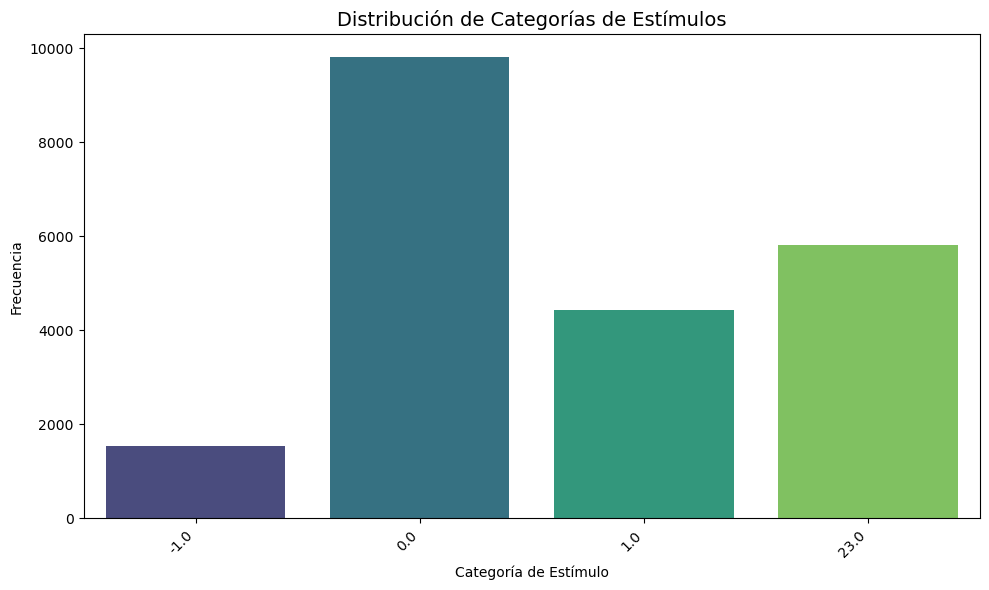

In [18]:
plt.figure(figsize=(10, 6)) # Tamaño mediano
sns.countplot(data=df_rms_imbalanced, x='restimulus', palette='viridis')
plt.title('Distribución de Categorías de Estímulos', fontsize=14) # Título resaltado
plt.xlabel('Categoría de Estímulo')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Se eliminan todos los registros asociados a las ventanas cuya etiqueta se asocia a una transición

In [19]:
# Eliminar todas las filas donde restimulus_cat == -1 en df_rms_imbalanced
df_rms_imbalanced = df_rms_imbalanced[df_rms_imbalanced['restimulus_cat'] != -1]
df_rms_imbalanced = df_rms_imbalanced.reset_index(drop=True)
df_rms_imbalanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20043 entries, 0 to 20042
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   RMS_ch1         20043 non-null  float64 
 1   RMS_ch2         20043 non-null  float64 
 2   RMS_ch3         20043 non-null  float64 
 3   RMS_ch4         20043 non-null  float64 
 4   RMS_ch5         20043 non-null  float64 
 5   RMS_ch6         20043 non-null  float64 
 6   RMS_ch7         20043 non-null  float64 
 7   RMS_ch8         20043 non-null  float64 
 8   RMS_ch9         20043 non-null  float64 
 9   RMS_ch10        20043 non-null  float64 
 10  restimulus      20043 non-null  float64 
 11  subject         20043 non-null  int64   
 12  restimulus_cat  20043 non-null  category
 13  subject_cat     20043 non-null  category
dtypes: category(2), float64(11), int64(1)
memory usage: 1.9 MB


En la siguiente grafica se verifica el procedimiento previo.

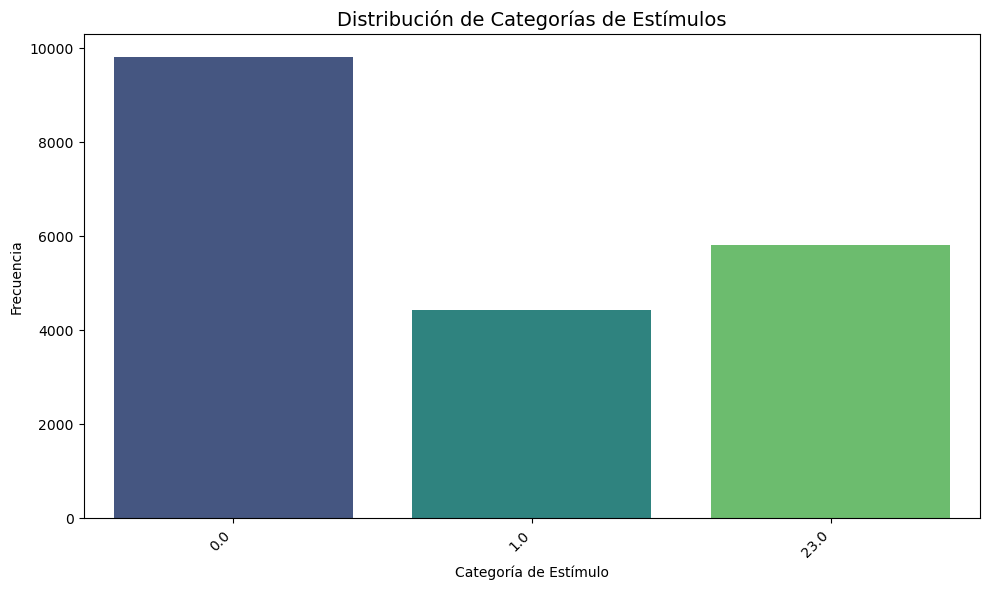

In [20]:
plt.figure(figsize=(10, 6)) # Tamaño mediano
sns.countplot(data=df_rms_imbalanced, x='restimulus', palette='viridis')
plt.title('Distribución de Categorías de Estímulos', fontsize=14) # Título resaltado
plt.xlabel('Categoría de Estímulo')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [21]:
df_rms_imbalanced.head()

,RMS_ch1,RMS_ch2,RMS_ch3,RMS_ch4,RMS_ch5,RMS_ch6,RMS_ch7,RMS_ch8,RMS_ch9,RMS_ch10,restimulus,subject,restimulus_cat,subject_cat
0,0.186650,0.064954,0.007956,0.002370,0.002316,0.002340,0.011819,0.025321,0.002160,0.021807,0.0,10,0.0,10
1,0.147451,0.024014,0.010991,0.002311,0.002293,0.003349,0.061164,0.166142,0.001954,0.076644,0.0,10,0.0,10
2,0.399017,0.076350,0.197038,0.002660,0.003711,0.007535,0.219384,0.941561,0.005587,0.659597,1.0,10,1.0,10
3,0.664900,0.140433,0.336471,0.003742,0.006055,0.008054,0.247355,1.144152,0.011067,0.949690,1.0,10,1.0,10
4,0.955840,0.202396,0.380185,0.005046,0.008593,0.007723,0.239447,1.084849,0.013835,1.068361,1.0,10,1.0,10


In [22]:
# Contar los valores únicos en la columna 'restimulus'
unique_counts = df_rms_imbalanced['restimulus'].value_counts()

# Mostrar los resultados
print("Cantidad de datos únicos en 'restimulus':")
print(unique_counts)

Cantidad de datos únicos en 'restimulus':
restimulus
0.0     9809
23.0    5810
1.0     4424
Name: count, dtype: int64


## 5. Modelos

### 5.1. Clustering Kmeans empleando el dataset con las caracteristicas RMS sin balancear 

Inicialmente se separan las caracteristicas de la respuesta.

In [40]:
# Separar las entradas (features) y la salida (target)
X = df_rms_imbalanced.drop(columns=['restimulus','subject','restimulus_cat','subject_cat'])  # Entradas
y_original = df_rms_imbalanced['restimulus']  # Salida

# Mostrar las dimensiones de las entradas y la salida
print(f"Dimensiones de X (entradas): {X.shape}")
print(f"Dimensiones de y (salida): {y.shape}")

Dimensiones de X (entradas): (20043, 10)
Dimensiones de y (salida): (20043,)


In [ ]:
# Mapeo de etiquetas a 0, 1, 2
label_mapping = {0.0: 0, 1.0: 1, 23.0: 2}
y = y_original.map(label_mapping)

# Verificar el mapeo
print("Etiquetas originales:", y_original.unique())
print("Etiquetas mapeadas:", y.unique())

Etiquetas originales: [ 0.  1. 23.]
Etiquetas mapeadas: [0 1 2]


Se aplica el clustering kmeans para varios clusters distintos.

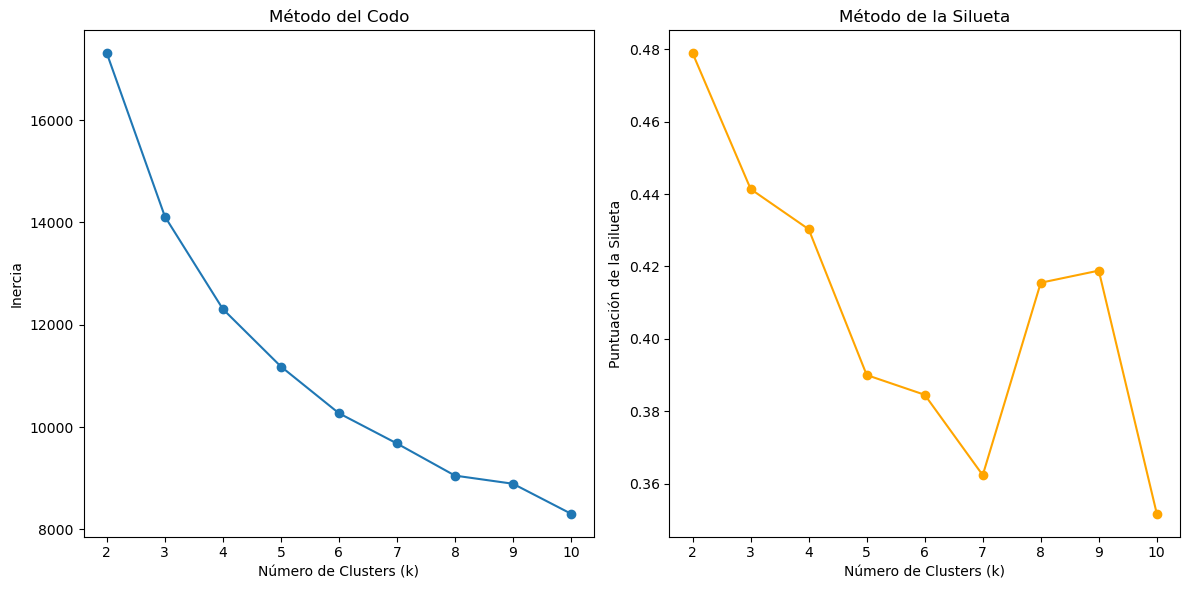

In [42]:
# Diccionario para almacenar los modelos KMeans
kmeans_models = {}

# Inicializar listas para inercia y silueta
inertia = []
silhouette_scores = []

# Entrenar KMeans para k de 2 a 10 y guardar los modelos en el diccionario
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    kmeans_models[k] = kmeans
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Graficar la inercia (método del codo)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')

# Graficar la puntuación de la silueta
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o', color='orange')
plt.title('Método de la Silueta')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Puntuación de la Silueta')

plt.tight_layout()
plt.show()

Tomando como base la figura anterior, se seleccionan 3 clusters como numero optimo

In [43]:
NUM_CLUSTERS = 3 # Número óptimo de clusters según el método del codo y la silueta
k = NUM_CLUSTERS  

# Extraer el modelo óptimo del diccionario
kmeans_optimal = kmeans_models[k]

# Mostrar el modelo óptimo
kmeans_optimal

KMeans(n_clusters=3, random_state=42)

Se muestran los centroides

In [44]:
# Obtener los valores de los clusters (centroides)
cluster_centers = kmeans_optimal.cluster_centers_

# Mostrar los valores de los clusters
print("Valores de los clusters (centroides):")
print(cluster_centers)

Valores de los clusters (centroides):
[[0.35451316 0.62962533 0.51152452 0.27017533 0.16348004 0.60478663
  1.83471812 1.33563815 0.56010935 1.10390432]
 [0.13723852 0.05727898 0.03835781 0.02656683 0.01295606 0.05505436
  0.15266516 0.1892172  0.05143656 0.11623179]
 [0.77335027 0.39122094 0.32585958 0.12532761 0.05047082 0.11391244
  0.56352487 0.95245065 0.29053339 0.35969222]]


In [45]:
# Entrenar KMeans con el número óptimo de clusters
kmeans_optimal.fit(X)

# Asignar las etiquetas de los clusters al conjunto de datos de entrenamiento
X['cluster'] = kmeans_optimal.labels_

# Mostrar las primeras filas con las etiquetas de los clusters
X.head()

,RMS_ch1,RMS_ch2,RMS_ch3,RMS_ch4,RMS_ch5,RMS_ch6,RMS_ch7,RMS_ch8,RMS_ch9,RMS_ch10,cluster
0,0.186650,0.064954,0.007956,0.002370,0.002316,0.002340,0.011819,0.025321,0.002160,0.021807,1
1,0.147451,0.024014,0.010991,0.002311,0.002293,0.003349,0.061164,0.166142,0.001954,0.076644,1
2,0.399017,0.076350,0.197038,0.002660,0.003711,0.007535,0.219384,0.941561,0.005587,0.659597,2
3,0.664900,0.140433,0.336471,0.003742,0.006055,0.008054,0.247355,1.144152,0.011067,0.949690,2
4,0.955840,0.202396,0.380185,0.005046,0.008593,0.007723,0.239447,1.084849,0.013835,1.068361,2


In [47]:
# Contar valores unicos del dataset original
restimulus_original_counts = y_original.value_counts()
print("Valores únicos en 'restimulus' (original):")
print(restimulus_original_counts)

# Contar valores debido al mapeo de los tags orinales
restimulus_cat_counts = y.value_counts()
print("\nValores únicos en 'restimulus_cat':")
print(restimulus_cat_counts)

# Contar valores generados por el KMeans
cluster_counts = X['cluster'].value_counts()
print("\nValores únicos en 'Cluster':")
print(cluster_counts)

Valores únicos en 'restimulus' (original):
restimulus
0.0     9809
23.0    5810
1.0     4424
Name: count, dtype: int64

Valores únicos en 'restimulus_cat':
restimulus
0    9809
2    5810
1    4424
Name: count, dtype: int64

Valores únicos en 'Cluster':
cluster
1    12774
2     5782
0     1487
Name: count, dtype: int64


In [48]:
# Agregar una nueva columna 'restimulus_Cluster' con el mismo contenido de la columna 'Cluster'
X['restimulus_map'] = y
X['restimulus_original'] = y_original
# Verificar los cambios
X.head()

,RMS_ch1,RMS_ch2,RMS_ch3,RMS_ch4,RMS_ch5,RMS_ch6,RMS_ch7,RMS_ch8,RMS_ch9,RMS_ch10,cluster,restimulus_map,restimulus_original
0,0.186650,0.064954,0.007956,0.002370,0.002316,0.002340,0.011819,0.025321,0.002160,0.021807,1,0,0.0
1,0.147451,0.024014,0.010991,0.002311,0.002293,0.003349,0.061164,0.166142,0.001954,0.076644,1,0,0.0
2,0.399017,0.076350,0.197038,0.002660,0.003711,0.007535,0.219384,0.941561,0.005587,0.659597,2,1,1.0
3,0.664900,0.140433,0.336471,0.003742,0.006055,0.008054,0.247355,1.144152,0.011067,0.949690,2,1,1.0
4,0.955840,0.202396,0.380185,0.005046,0.008593,0.007723,0.239447,1.084849,0.013835,1.068361,2,1,1.0


Desempeño

In [49]:
# Calcular el ARI para KMeans
ari_score_kmeans = adjusted_rand_score(X['cluster'], X['restimulus_map'])

# Mostrar el resultado
print(f"Adjusted Rand Index (ARI) para KMeans: {ari_score_kmeans:.4f}")

Adjusted Rand Index (ARI) para KMeans: 0.4303


> **Conclusión**: 
> 
> * El desempeño fue malo.
> * Vamos a pasar realizar una tranformación reduciendo la dimensión de la entrada mediante el uso de PCA antes de la aplicación del clustering.

### 5.2. Clustering Kmeans + PCA empleando el dataset con las caracteristicas RMS sin balancear 

#### 5.2.1. PCA

Se realiza una reducción de dimensionalidad aplicando PCA

In [52]:
df_rms_imbalanced = dict_imbalanced['RMS'].copy()
df_rms_imbalanced = df_rms_imbalanced[df_rms_imbalanced['restimulus_cat'] != -1]
df_rms_imbalanced = df_rms_imbalanced.reset_index(drop=True)
df_rms_imbalanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20043 entries, 0 to 20042
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RMS_ch1         20043 non-null  float64
 1   RMS_ch2         20043 non-null  float64
 2   RMS_ch3         20043 non-null  float64
 3   RMS_ch4         20043 non-null  float64
 4   RMS_ch5         20043 non-null  float64
 5   RMS_ch6         20043 non-null  float64
 6   RMS_ch7         20043 non-null  float64
 7   RMS_ch8         20043 non-null  float64
 8   RMS_ch9         20043 non-null  float64
 9   RMS_ch10        20043 non-null  float64
 10  restimulus      20043 non-null  float64
 11  subject         20043 non-null  int64  
 12  restimulus_cat  20043 non-null  float64
 13  subject_cat     20043 non-null  int64  
dtypes: float64(12), int64(2)
memory usage: 2.1 MB


In [53]:
# Contar los valores únicos en la columna 'restimulus'
unique_counts = df_rms_imbalanced['restimulus'].value_counts()

# Mostrar los resultados
print("Cantidad de datos únicos en 'restimulus':")
print(unique_counts)

Cantidad de datos únicos en 'restimulus':
restimulus
0.0     9809
23.0    5810
1.0     4424
Name: count, dtype: int64


In [54]:
# Separar las entradas (features) y la salida (target)
X = df_rms_imbalanced.drop(columns=['restimulus','subject','restimulus_cat','subject_cat'])  # Entradasy = f_frms_imbalanced['restimulus']  # Salida
y_original = df_rms_imbalanced['restimulus']  # Salidada

# Mostrar las dimensiones de las entradas y la salida
print(f"Dimensiones de X (entradas): {X.shape}")
print(f"Dimensiones de y (salida): {y_original.shape}")

Dimensiones de X (entradas): (20043, 10)
Dimensiones de y (salida): (20043,)


In [55]:
# Mapeo de etiquetas a 0, 1, 2
label_mapping = {0.0: 0, 1.0: 1, 23.0: 2}
y = y_original.map(label_mapping)

# Verificar el mapeo
print("Etiquetas originales:", y_original.unique())
print("Etiquetas mapeadas:", y.unique())

Etiquetas originales: [ 0.  1. 23.]
Etiquetas mapeadas: [0 1 2]


In [56]:
X.head()

,RMS_ch1,RMS_ch2,RMS_ch3,RMS_ch4,RMS_ch5,RMS_ch6,RMS_ch7,RMS_ch8,RMS_ch9,RMS_ch10
0,0.186650,0.064954,0.007956,0.002370,0.002316,0.002340,0.011819,0.025321,0.002160,0.021807
1,0.147451,0.024014,0.010991,0.002311,0.002293,0.003349,0.061164,0.166142,0.001954,0.076644
2,0.399017,0.076350,0.197038,0.002660,0.003711,0.007535,0.219384,0.941561,0.005587,0.659597
3,0.664900,0.140433,0.336471,0.003742,0.006055,0.008054,0.247355,1.144152,0.011067,0.949690
4,0.955840,0.202396,0.380185,0.005046,0.008593,0.007723,0.239447,1.084849,0.013835,1.068361


Antes de aplicar PCA se escalan los datos

In [57]:
sc = StandardScaler()
X_std = pd.DataFrame(sc.fit_transform(X), columns = X.columns)
X_std.head()

,RMS_ch1,RMS_ch2,RMS_ch3,RMS_ch4,RMS_ch5,RMS_ch6,RMS_ch7,RMS_ch8,RMS_ch9,RMS_ch10
0,-0.313937,-0.443419,-0.570239,-0.363508,-0.467452,-0.429429,-0.701383,-0.828060,-0.561009,-0.616970
1,-0.395883,-0.581843,-0.558581,-0.363807,-0.467779,-0.425508,-0.611321,-0.579515,-0.561751,-0.474821
2,0.130021,-0.404888,0.156013,-0.362019,-0.447473,-0.409242,-0.322549,0.789070,-0.548689,1.036323
3,0.685854,-0.188218,0.691566,-0.356459,-0.413906,-0.407227,-0.271497,1.146635,-0.528983,1.788309
4,1.294069,0.021285,0.859470,-0.349763,-0.377559,-0.408512,-0.285931,1.041969,-0.519028,2.095929


Se aplica PCA sin definir el numero de clusters

In [58]:
#define PCA model to use
# N = 8
pca = PCA(n_components = None)

#fit PCA model to data
pca_fit = pca.fit(X_std)

# Varianza de cada componente principal
pca.explained_variance_

array([4.86323353, 1.42397942, 0.98407563, 0.65226801, 0.61011086,
       0.43209867, 0.4154074 , 0.26415187, 0.24232473, 0.11284883])

In [59]:
# Numero de componentes
pca.n_components_

10

In [60]:
# Proporción de varianza explicada
np_pca = pca.explained_variance_ratio_
np_pca

array([0.48629909, 0.14239084, 0.09840265, 0.06522355, 0.06100804,
       0.04320771, 0.04153867, 0.02641387, 0.02423126, 0.01128432])

Se grafica la varianza aportada de acuerdo al numero de componentes principales empleados

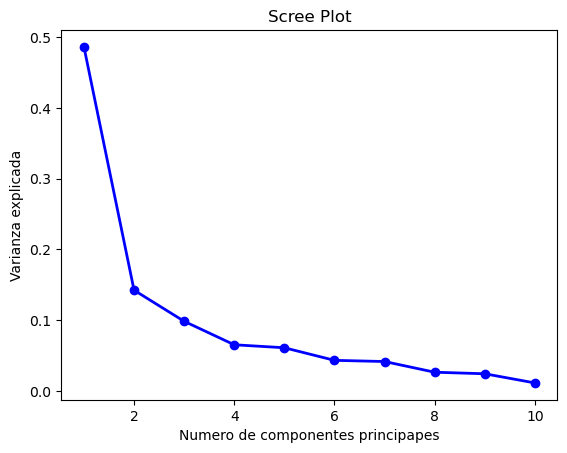

In [61]:
# Grafica de la proporcion de la varianza explicada
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Numero de componentes principapes')
plt.ylabel('Varianza explicada')
plt.show()

Se resume la grafica anterior en una tabla.

In [62]:
# Resumen
variance_df = pd.DataFrame({
    'Numero de Componentes': range(1, len(np_pca) + 1),
    'Varianza Explicada': np_pca,
    'Varianza Acumulativa': np.cumsum(np_pca)
})
variance_df

,Numero de Componentes,Varianza Explicada,Varianza Acumulativa
0,1,0.486299,0.486299
1,2,0.142391,0.628690
2,3,0.098403,0.727093
3,4,0.065224,0.792316
4,5,0.061008,0.853324
5,6,0.043208,0.896532
6,7,0.041539,0.938071
7,8,0.026414,0.964484
8,9,0.024231,0.988716
9,10,0.011284,1.000000


Vamos a elegir N = 8 componentes pues estos explican el 96% de la varianza

In [63]:
N_COMPONENTS = 8
SEED = 42
pca = PCA(n_components = N_COMPONENTS, random_state = SEED)
pca

PCA(n_components=8, random_state=42)

In [64]:
pca.fit(X_std)

PCA(n_components=8, random_state=42)

In [65]:
pca.components_

array([[ 0.18840465,  0.35004846,  0.34865504,  0.25466307,  0.34777926,
         0.28581264,  0.364625  ,  0.31321683,  0.33639327,  0.32969722],
       [ 0.57128981,  0.24136067,  0.29772704, -0.03375078, -0.36884532,
        -0.5275467 , -0.22029565,  0.19608859,  0.12399246, -0.09426058],
       [-0.19160663, -0.17867737,  0.22345106,  0.74528041,  0.08446298,
        -0.23547299, -0.23817214, -0.36705256,  0.26279851, -0.05375787],
       [ 0.11486697, -0.02059115, -0.12090031,  0.19762349, -0.29897993,
        -0.18454556,  0.28217381, -0.24050187, -0.3898612 ,  0.72097755],
       [ 0.63532346,  0.12968624, -0.12381655,  0.11674477,  0.34097729,
         0.31220382, -0.1954312 , -0.42385554, -0.30597244, -0.15932026],
       [-0.37022139,  0.66899543,  0.24669557,  0.08691775, -0.01524294,
        -0.11443716,  0.14798878, -0.12082968, -0.4625955 , -0.28834794],
       [ 0.06887508, -0.13878539, -0.34924664,  0.44723344,  0.20653582,
        -0.19058477,  0.01808703,  0.63689474

In [66]:
pca.explained_variance_ratio_

array([0.48629909, 0.14239084, 0.09840265, 0.06522355, 0.06100804,
       0.04320771, 0.04153867, 0.02641387])

In [67]:
X_pca = pca.transform(X_std)
components_labels = ['PC' + str(i) for i in list(range(1,N_COMPONENTS + 1))]
projected_pca_X = pd.DataFrame(X_pca, columns = components_labels)
projected_pca_X.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-1.698297,-0.064185,0.159408,-0.035686,0.235750,0.137258,-0.167487,-0.097575
1,-1.599892,-0.127471,0.080758,0.024070,0.020001,0.020049,-0.021321,-0.008278
2,-0.140982,0.476232,-0.541656,0.822467,-0.580468,-0.446406,0.374441,0.354082
3,0.625140,0.982314,-0.739347,1.270688,-0.540191,-0.636976,0.306332,0.566272
4,0.952310,1.372276,-0.819503,1.545637,-0.139495,-0.763194,0.151671,0.559727


In [68]:
# Se verificar que la cantidad de filas en el DataFrame original y el transformado son iguales
projected_pca_X.shape[0] == X.shape[0]

True

Ahora se aplica el kmeans sobre los datos PCA.

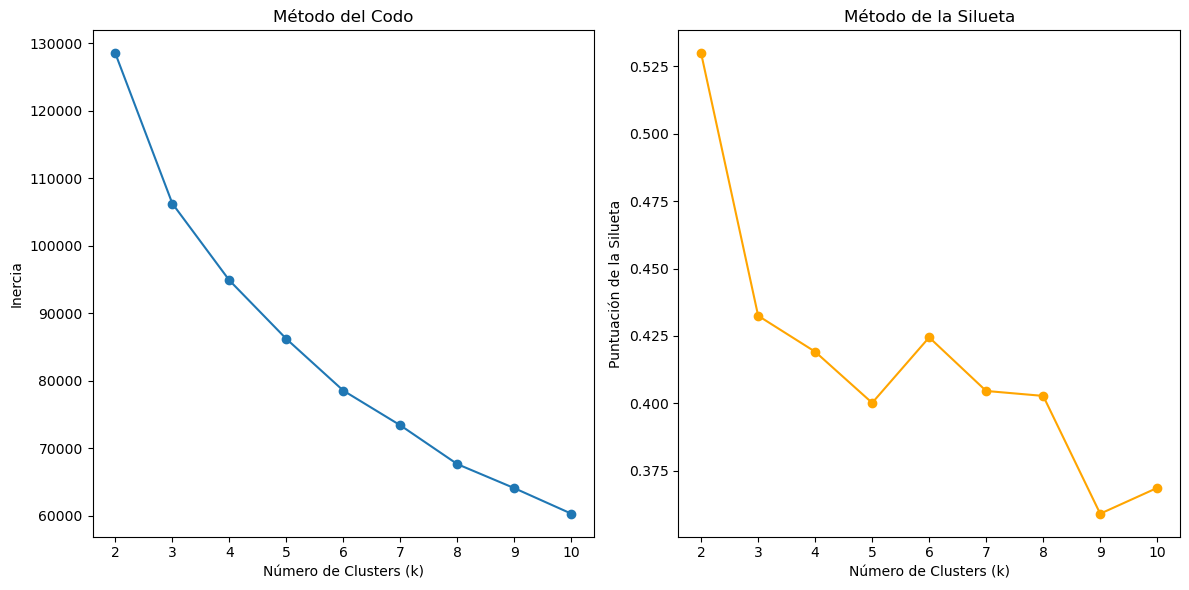

In [69]:
# Diccionario para almacenar los modelos KMeans
kmeans_pca_models = {}

# Inicializar listas para inercia y silueta
inertia = []
silhouette_scores = []

# Entrenar KMeans para k de 2 a 10 y guardar los modelos en el diccionario
for k in range(2, 11):
    kmeans_pca = KMeans(n_clusters=k, random_state=42)
    kmeans_pca.fit(X_pca)
    kmeans_pca_models[k] = kmeans_pca
    inertia.append(kmeans_pca.inertia_)
    silhouette_scores.append(silhouette_score(X_std, kmeans_pca.labels_))

# Graficar la inercia (método del codo)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')

# Graficar la puntuación de la silueta
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o', color='orange')
plt.title('Método de la Silueta')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Puntuación de la Silueta')

plt.tight_layout()
plt.show()

Se emplean 3 clusters

In [70]:
NUM_CLUSTERS = 3 # Número óptimo de clusters según el método del codo y la silueta
k = NUM_CLUSTERS  

# Extraer el modelo óptimo del diccionario
kmeans_pca_optimal = kmeans_pca_models[k]

# Mostrar el modelo óptimo
kmeans_pca_optimal

KMeans(n_clusters=3, random_state=42)

In [71]:
# Obtener los valores de los clusters (centroides)
cluster_pca_centers = kmeans_pca_optimal.cluster_centers_

# Mostrar los valores de los clusters
print("Valores de los clusters (centroides):")
print(cluster_pca_centers)

Valores de los clusters (centroides):
[[ 5.81458247e+00 -1.28695763e+00  5.86761534e-01 -3.12347908e-02
   6.95336900e-02 -3.16065780e-02 -8.71251382e-02 -1.14661422e-01]
 [-1.27543442e+00 -2.11644090e-01  5.13420135e-02  2.18101466e-03
   6.82345997e-04  1.83248384e-02 -4.22169017e-02 -2.96822188e-02]
 [ 1.45557642e+00  7.74965293e-01 -2.53036692e-01  2.55469032e-03
  -1.79872807e-02 -3.32156898e-02  1.14410491e-01  9.30916178e-02]]


In [72]:
# Entrenar KMeans con el número óptimo de clusters
kmeans_pca_optimal.fit(X_pca)

# Asignar las etiquetas de los clusters al conjunto de datos de entrenamiento
X['cluster_pca'] = kmeans_pca_optimal.labels_

# Mostrar las primeras filas con las etiquetas de los clusters
X.head()

,RMS_ch1,RMS_ch2,RMS_ch3,RMS_ch4,RMS_ch5,RMS_ch6,RMS_ch7,RMS_ch8,RMS_ch9,RMS_ch10,cluster_pca
0,0.186650,0.064954,0.007956,0.002370,0.002316,0.002340,0.011819,0.025321,0.002160,0.021807,1
1,0.147451,0.024014,0.010991,0.002311,0.002293,0.003349,0.061164,0.166142,0.001954,0.076644,1
2,0.399017,0.076350,0.197038,0.002660,0.003711,0.007535,0.219384,0.941561,0.005587,0.659597,1
3,0.664900,0.140433,0.336471,0.003742,0.006055,0.008054,0.247355,1.144152,0.011067,0.949690,2
4,0.955840,0.202396,0.380185,0.005046,0.008593,0.007723,0.239447,1.084849,0.013835,1.068361,2


In [73]:
# Contar valores unicos del dataset original
restimulus_original_counts = y_original.value_counts()
print("Valores únicos en 'restimulus' (original):")
print(restimulus_original_counts)

# Contar valores debido al mapeo de los tags orinales
restimulus_cat_counts = y.value_counts()
print("\nValores únicos en 'restimulus_cat':")
print(restimulus_cat_counts)

# Contar valores generados por el KMeans
cluster_counts = X['cluster_pca'].value_counts()
print("\nValores únicos en 'Cluster':")
print(cluster_counts)

Valores únicos en 'restimulus' (original):
restimulus
0.0     9809
23.0    5810
1.0     4424
Name: count, dtype: int64

Valores únicos en 'restimulus_cat':
restimulus
0    9809
2    5810
1    4424
Name: count, dtype: int64

Valores únicos en 'Cluster':
cluster_pca
1    12868
2     5799
0     1376
Name: count, dtype: int64


Desempeño

In [74]:
# Agregar una nueva columna 'restimulus_Cluster' con el mismo contenido de la columna 'Cluster'
# X['cluster_pca'] = X['cluster_pca'].replace({1: 0, 2: 23, 0: 1}) # No es necesario por lo menos aca
X['restimulus_map'] = y
X['restimulus_original'] = y_original
# Verificar los cambios
X.head()

,RMS_ch1,RMS_ch2,RMS_ch3,RMS_ch4,RMS_ch5,RMS_ch6,RMS_ch7,RMS_ch8,RMS_ch9,RMS_ch10,cluster_pca,restimulus_map,restimulus_original
0,0.186650,0.064954,0.007956,0.002370,0.002316,0.002340,0.011819,0.025321,0.002160,0.021807,1,0,0.0
1,0.147451,0.024014,0.010991,0.002311,0.002293,0.003349,0.061164,0.166142,0.001954,0.076644,1,0,0.0
2,0.399017,0.076350,0.197038,0.002660,0.003711,0.007535,0.219384,0.941561,0.005587,0.659597,1,1,1.0
3,0.664900,0.140433,0.336471,0.003742,0.006055,0.008054,0.247355,1.144152,0.011067,0.949690,2,1,1.0
4,0.955840,0.202396,0.380185,0.005046,0.008593,0.007723,0.239447,1.084849,0.013835,1.068361,2,1,1.0


Medimos el desempeño.

In [76]:
# Calcular el ARI para KMeans
ari_score_kmeans = adjusted_rand_score(X['restimulus_map'], X['cluster_pca'])
# Mostrar el resultado
print(f"Adjusted Rand Index (ARI) para KMeans: {ari_score_kmeans:.4f}")

Adjusted Rand Index (ARI) para KMeans: 0.4189


> **Conclusión**:
>
> * Aplicar PCA con los datos desbalanceados fue un poco mas malo que el anterior pero muy cercano. 
> * Justifica aplicar PCA por que la red se entrena con dos caracteristicas menos, por lo cual es una compresión que vale la pena tener en cuenta para los resultados que se dieron.

### 5.3. Clustering Kmeans + PCA empleando el dataset balanceado con las caracteristicas RMS

Sigue siendo malo. Veamos que pasa si se balancea la entrada

In [77]:
for feature_name, df in dict_balanced.items():
    print(f"{feature_name}: {df.shape}")

IAV: (13272, 11)
RMS: (13272, 11)
WL: (13272, 11)


In [79]:
df_rms_balanced = dict_balanced['RMS'].copy()
df_rms_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13272 entries, 0 to 13271
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RMS_ch1     13272 non-null  float64
 1   RMS_ch2     13272 non-null  float64
 2   RMS_ch3     13272 non-null  float64
 3   RMS_ch4     13272 non-null  float64
 4   RMS_ch5     13272 non-null  float64
 5   RMS_ch6     13272 non-null  float64
 6   RMS_ch7     13272 non-null  float64
 7   RMS_ch8     13272 non-null  float64
 8   RMS_ch9     13272 non-null  float64
 9   RMS_ch10    13272 non-null  float64
 10  restimulus  13272 non-null  float64
dtypes: float64(11)
memory usage: 1.1 MB


In [80]:
df_rms_balanced['restimulus'].value_counts()

restimulus
0.0     4424
1.0     4424
23.0    4424
Name: count, dtype: int64

Vemos que los datos estan balanceados, a continuación analizamos la forma del dataset:

In [81]:
df_rms_balanced.head()

,RMS_ch1,RMS_ch2,RMS_ch3,RMS_ch4,RMS_ch5,RMS_ch6,RMS_ch7,RMS_ch8,RMS_ch9,RMS_ch10,restimulus
0,0.002971,0.002011,0.002235,0.002222,0.004159,0.011375,0.168135,0.424274,0.008702,0.178665,0.0
1,0.002682,0.002494,0.003043,0.002453,0.014639,0.133269,0.051355,0.055463,0.035154,0.531450,0.0
2,0.002399,0.002400,0.002487,0.002398,0.004415,0.133537,0.006214,0.002398,0.015982,0.008684,0.0
3,0.972779,0.024917,0.002912,0.002560,0.002688,0.017993,0.084669,0.466418,0.002400,0.094062,0.0
4,0.245827,0.009948,0.004982,0.003690,0.004121,0.003417,0.033055,0.097625,0.003520,0.074589,0.0


Repitamos el proceso para obtener los coeficientes PCA pero en esta ocasión empleando el conjunto de datos ya balanceado.

In [82]:
# Separar las entradas (features) y la salida (target)
X = df_rms_balanced.drop(columns=['restimulus'])  # Entradas
y_original = df_rms_balanced['restimulus']  # Salida

# Mostrar las dimensiones de las entradas y la salida
print(f"Dimensiones de X (entradas): {X.shape}")
print(f"Dimensiones de y (salida): {y_original.shape}")

Dimensiones de X (entradas): (13272, 10)
Dimensiones de y (salida): (13272,)


In [83]:
label_mapping = {0.0: 0, 1.0: 1, 23.0: 2}
y = y_original.map(label_mapping)

# Verificar el mapeo
print("Etiquetas originales:", y_original.unique())
print("Etiquetas mapeadas:", y.unique())

Etiquetas originales: [ 0.  1. 23.]
Etiquetas mapeadas: [0 1 2]


Aplicación del escalador

In [84]:
sc = StandardScaler()
X_std = pd.DataFrame(sc.fit_transform(X), columns = X.columns)
X_std.head()

,RMS_ch1,RMS_ch2,RMS_ch3,RMS_ch4,RMS_ch5,RMS_ch6,RMS_ch7,RMS_ch8,RMS_ch9,RMS_ch10
0,-0.764868,-0.758250,-0.697944,-0.416049,-0.516073,-0.446097,-0.542486,-0.254415,-0.622900,-0.333331
1,-0.765438,-0.756687,-0.695033,-0.415048,-0.383861,-0.031933,-0.738028,-0.880796,-0.536154,0.470448
2,-0.765998,-0.756992,-0.697038,-0.415283,-0.512843,-0.031022,-0.813615,-0.970920,-0.599025,-0.720613
3,1.152438,-0.684164,-0.695505,-0.414581,-0.534637,-0.423613,-0.682246,-0.182837,-0.643567,-0.526088
4,-0.284742,-0.732579,-0.688042,-0.409671,-0.516558,-0.473138,-0.768670,-0.809190,-0.639894,-0.570456


Aplicación del PCA

In [85]:
#define PCA model to use
# N = 8
pca = PCA(n_components = None)

#fit PCA model to data
pca_fit = pca.fit(X_std)

# Varianza de cada componente principal
pca.explained_variance_

array([4.51356818, 1.47761059, 1.05594279, 0.71637933, 0.67182376,
       0.45690189, 0.45179105, 0.27915396, 0.26415635, 0.11342562])

In [86]:
# Numero de componentes
pca.n_components_

10

In [87]:
# Proporción de varianza explicada
np_pca = pca.explained_variance_ratio_
np_pca

array([0.45132281, 0.14774993, 0.10558632, 0.07163254, 0.06717731,
       0.04568675, 0.0451757 , 0.02791329, 0.02641365, 0.01134171])

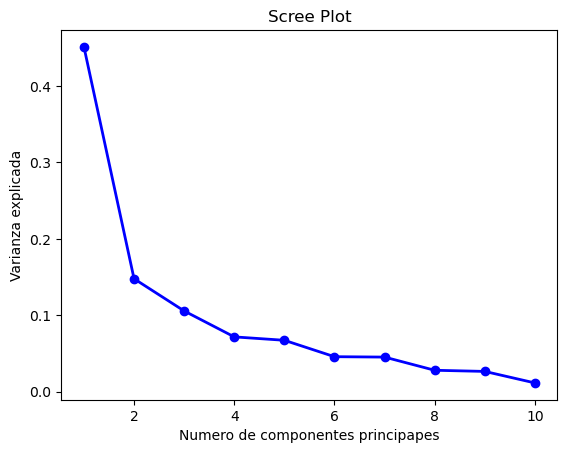

In [88]:
# Grafica de la proporcion de la varianza explicada
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Numero de componentes principapes')
plt.ylabel('Varianza explicada')
plt.show()

In [90]:
# Resumen
variance_df = pd.DataFrame({
    'Numero de Componentes': range(1, len(np_pca) + 1),
    'Varianza Explicada': np_pca,
    'Varianza Acumulativa': np.cumsum(np_pca)
})
variance_df

,Numero de Componentes,Varianza Explicada,Varianza Acumulativa
0,1,0.451323,0.451323
1,2,0.147750,0.599073
2,3,0.105586,0.704659
3,4,0.071633,0.776292
4,5,0.067177,0.843469
5,6,0.045687,0.889156
6,7,0.045176,0.934331
7,8,0.027913,0.962245
8,9,0.026414,0.988658
9,10,0.011342,1.000000


Con 8 componentes se puede explicar el 96% de la variabilidad

In [91]:
N_COMPONENTS = 8
SEED = 42
pca = PCA(n_components = N_COMPONENTS, random_state = SEED)
pca

PCA(n_components=8, random_state=42)

In [92]:
pca.fit(X_std)

PCA(n_components=8, random_state=42)

In [93]:
pca.components_

array([[ 0.17271153,  0.35182776,  0.35337052,  0.25410373,  0.35198348,
         0.29061319,  0.36718907,  0.29913104,  0.33956924,  0.33012977],
       [ 0.56217924,  0.26231921,  0.29695177, -0.04725212, -0.37680543,
        -0.51797256, -0.21280853,  0.21526977,  0.12518915, -0.08456501],
       [-0.1903188 , -0.1763753 ,  0.25327948,  0.71265362,  0.08646983,
        -0.23790939, -0.26178647, -0.36665511,  0.29187526, -0.09169309],
       [ 0.16302503, -0.01644214, -0.11054731,  0.23520255, -0.26038851,
        -0.17838563,  0.27226636, -0.3191554 , -0.38975444,  0.69144073],
       [ 0.61783978,  0.16597133, -0.09978698,  0.0786641 ,  0.36116667,
         0.31472328, -0.21954491, -0.42689842, -0.25569686, -0.22196129],
       [ 0.17862224, -0.28162345, -0.3963412 ,  0.43210684,  0.23621391,
        -0.14749094, -0.08914704,  0.62675884, -0.25659892, -0.0284995 ],
       [-0.35017757,  0.62388392,  0.0966031 ,  0.21714268,  0.02649128,
        -0.17013802,  0.17019485,  0.04122988

In [94]:
X_pca = pca.transform(X_std)
components_labels = ['PC' + str(i) for i in list(range(1,N_COMPONENTS + 1))]
projected_pca_X = pd.DataFrame(X_pca, columns = components_labels)
projected_pca_X.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-1.659377,-0.380082,-0.048409,0.026828,-0.427312,0.175897,0.025445,-0.023948
1,-1.455108,-0.793859,0.098247,0.586945,-0.139776,-0.275546,-0.409567,-0.281183
2,-1.970481,-0.657173,0.230056,-0.170412,0.149226,-0.305140,-0.003268,-0.016086
3,-1.401495,0.772090,-0.409681,0.152956,0.818012,0.557589,-0.549909,0.178328
4,-1.903387,-0.139970,0.148536,0.068176,0.207886,-0.059295,-0.093869,-0.022923


In [95]:
# Se verificar que la cantidad de filas en el DataFrame original y el transformado son iguales
projected_pca_X.shape[0] == X.shape[0]

True

Ahora se aplica el clustering usando kmeans

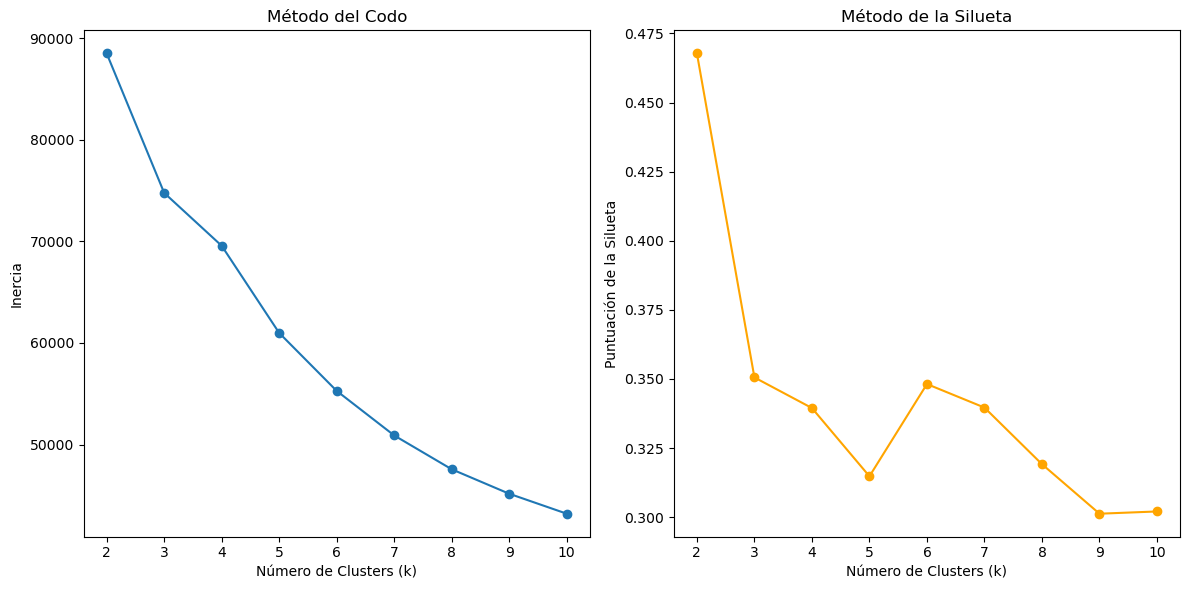

In [96]:
# Diccionario para almacenar los modelos KMeans
kmeans_pca_models = {}

# Inicializar listas para inercia y silueta
inertia = []
silhouette_scores = []

# Entrenar KMeans para k de 2 a 10 y guardar los modelos en el diccionario
for k in range(2, 11):
    kmeans_pca = KMeans(n_clusters=k, random_state=42)
    kmeans_pca.fit(X_pca)
    kmeans_pca_models[k] = kmeans_pca
    inertia.append(kmeans_pca.inertia_)
    silhouette_scores.append(silhouette_score(X_std, kmeans_pca.labels_))

# Graficar la inercia (método del codo)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')

# Graficar la puntuación de la silueta
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o', color='orange')
plt.title('Método de la Silueta')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Puntuación de la Silueta')

plt.tight_layout()
plt.show()

Eligiendo 3 clusters

In [97]:
NUM_CLUSTERS = 3 # Número óptimo de clusters según el método del codo y la silueta
k = NUM_CLUSTERS  

# Extraer el modelo óptimo del diccionario
kmeans_pca_optimal = kmeans_pca_models[k]

# Mostrar el modelo óptimo
kmeans_pca_optimal

KMeans(n_clusters=3, random_state=42)

In [98]:
# Obtener los valores de los clusters (centroides)
cluster_pca_centers = kmeans_pca_optimal.cluster_centers_

# Mostrar los valores de los clusters
print("Valores de los clusters (centroides):")
print(cluster_pca_centers)

Valores de los clusters (centroides):
[[ 4.86490277e+00 -1.13193050e+00  4.97102604e-01 -1.30630659e-03
   5.77256221e-02 -2.34830669e-02 -4.22772150e-02 -8.41861392e-02]
 [-1.34693161e+00 -2.66990370e-01  4.80996031e-02  4.22875431e-03
  -1.91874757e-02 -3.91732685e-02  7.14452734e-03 -3.24032603e-02]
 [ 1.09610443e+00  7.99374724e-01 -2.25423481e-01 -7.31980472e-03
   1.88290032e-02  7.76886082e-02 -1.23991466e-03  8.22457206e-02]]


In [99]:
# Entrenar KMeans con el número óptimo de clusters
kmeans_pca_optimal.fit(X_pca)

# Asignar las etiquetas de los clusters al conjunto de datos de entrenamiento
X['cluster_pca'] = kmeans_pca_optimal.labels_

# Mostrar las primeras filas con las etiquetas de los clusters
X.head()

,RMS_ch1,RMS_ch2,RMS_ch3,RMS_ch4,RMS_ch5,RMS_ch6,RMS_ch7,RMS_ch8,RMS_ch9,RMS_ch10,cluster_pca
0,0.002971,0.002011,0.002235,0.002222,0.004159,0.011375,0.168135,0.424274,0.008702,0.178665,1
1,0.002682,0.002494,0.003043,0.002453,0.014639,0.133269,0.051355,0.055463,0.035154,0.531450,1
2,0.002399,0.002400,0.002487,0.002398,0.004415,0.133537,0.006214,0.002398,0.015982,0.008684,1
3,0.972779,0.024917,0.002912,0.002560,0.002688,0.017993,0.084669,0.466418,0.002400,0.094062,1
4,0.245827,0.009948,0.004982,0.003690,0.004121,0.003417,0.033055,0.097625,0.003520,0.074589,1


In [ ]:
# Contar valores unicos del dataset original
restimulus_original_counts = y_original.value_counts()
print("Valores únicos en 'restimulus' (original):")
print(restimulus_original_counts)

# Contar valores debido al mapeo de los tags orinales
restimulus_cat_counts = y.value_counts()
print("\nValores únicos en 'restimulus_cat':")
print(restimulus_cat_counts)

# Contar valores generados por el KMeans
cluster_counts = X['cluster_pca'].value_counts()
print("\nValores únicos en 'Cluster':")
print(cluster_counts)

Valores únicos en 'restimulus' (original):
restimulus
0.0     4424
1.0     4424
23.0    4424
Name: count, dtype: int64

Valores únicos en 'restimulus_cat':
restimulus
0    4424
1    4424
2    4424
Name: count, dtype: int64

Valores únicos en 'Cluster':
cluster_pca
1    7783
2    4297
0    1192
Name: count, dtype: int64


In [102]:
X['restimulus_map'] = y
X['restimulus_original'] = y_original
# Verificar los cambios
X.head()

,RMS_ch1,RMS_ch2,RMS_ch3,RMS_ch4,RMS_ch5,RMS_ch6,RMS_ch7,RMS_ch8,RMS_ch9,RMS_ch10,cluster_pca,restimulus_map,restimulus_original
0,0.002971,0.002011,0.002235,0.002222,0.004159,0.011375,0.168135,0.424274,0.008702,0.178665,1,0,0.0
1,0.002682,0.002494,0.003043,0.002453,0.014639,0.133269,0.051355,0.055463,0.035154,0.531450,1,0,0.0
2,0.002399,0.002400,0.002487,0.002398,0.004415,0.133537,0.006214,0.002398,0.015982,0.008684,1,0,0.0
3,0.972779,0.024917,0.002912,0.002560,0.002688,0.017993,0.084669,0.466418,0.002400,0.094062,1,0,0.0
4,0.245827,0.009948,0.004982,0.003690,0.004121,0.003417,0.033055,0.097625,0.003520,0.074589,1,0,0.0


In [103]:
# Calcular el ARI para KMeans
ari_score_kmeans = adjusted_rand_score(X['restimulus_map'], X['cluster_pca'])
# Mostrar el resultado
print(f"Adjusted Rand Index (ARI) para KMeans: {ari_score_kmeans:.4f}")

Adjusted Rand Index (ARI) para KMeans: 0.1971


> **Conclusiones**:
>
> * Trabajar sobre los datos balanceados, en este caso especifico fue peor.
> * Se perdio mucha información del modelo.

### 5.4. Clustering Kmeans + uMAP empleando el dataset balanceado con las caracteristicas RMS

In [104]:
fd_rms_balanced = dict_balanced['RMS'].copy()
X = fd_rms_balanced
y_original = fd_rms_balanced['restimulus']

# Mostrar las dimensiones de las entradas y la salida
print(f"Dimensiones de X (entradas): {X.shape}")
print(f"Dimensiones de y (salida): {y_original.shape}")

Dimensiones de X (entradas): (13272, 11)
Dimensiones de y (salida): (13272,)


In [105]:
label_mapping = {0.0: 0, 1.0: 1, 23.0: 2}
y = y_original.map(label_mapping)

# Verificar el mapeo
print("Etiquetas originales:", y_original.unique())
print("Etiquetas mapeadas:", y.unique())

Etiquetas originales: [ 0.  1. 23.]
Etiquetas mapeadas: [0 1 2]


In [106]:
# Contar los valores únicos en la columna 'restimulus'
# unique_counts = fd_rms_imbalanced['restimulus'].value_counts()
unique_counts = fd_rms_balanced['restimulus'].value_counts()

# Mostrar los resultados
print("Cantidad de datos únicos en 'restimulus':")
print(unique_counts)

Cantidad de datos únicos en 'restimulus':
restimulus
0.0     4424
1.0     4424
23.0    4424
Name: count, dtype: int64


In [107]:
X.head()

,RMS_ch1,RMS_ch2,RMS_ch3,RMS_ch4,RMS_ch5,RMS_ch6,RMS_ch7,RMS_ch8,RMS_ch9,RMS_ch10,restimulus
0,0.002971,0.002011,0.002235,0.002222,0.004159,0.011375,0.168135,0.424274,0.008702,0.178665,0.0
1,0.002682,0.002494,0.003043,0.002453,0.014639,0.133269,0.051355,0.055463,0.035154,0.531450,0.0
2,0.002399,0.002400,0.002487,0.002398,0.004415,0.133537,0.006214,0.002398,0.015982,0.008684,0.0
3,0.972779,0.024917,0.002912,0.002560,0.002688,0.017993,0.084669,0.466418,0.002400,0.094062,0.0
4,0.245827,0.009948,0.004982,0.003690,0.004121,0.003417,0.033055,0.097625,0.003520,0.074589,0.0


Como ya se tiene la certeza que los datos estan balanceados y se conoce la forma de estos se puede proceder a escalar.

In [108]:
# Escalado los datos
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

Aplicando el escalado a los datos.

In [109]:
# Escalado los datos
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

Ahora definiendo los parametros del UMAP a malicia:

In [110]:
# Aplicacion UMAP
#N_NEIGHBORS = 30
#MIN_DIST = 0.3
N_COMPONENTS = 3
SEED = 42
# Define UMAP model
"""
umap_model = umap.UMAP(n_neighbors = N_NEIGHBORS,
                       min_dist = MIN_DIST,
                       n_components = N_COMPONENTS,
                       random_state = SEED)
"""
umap_model = umap.UMAP(n_components = N_COMPONENTS,
                       random_state = SEED)
umap_model

UMAP(n_components=3, random_state=42)

Ahora aplicando el UMAP sobre los datos escalados tenemos:

In [111]:
X_umap = umap_model.fit_transform(X_std)

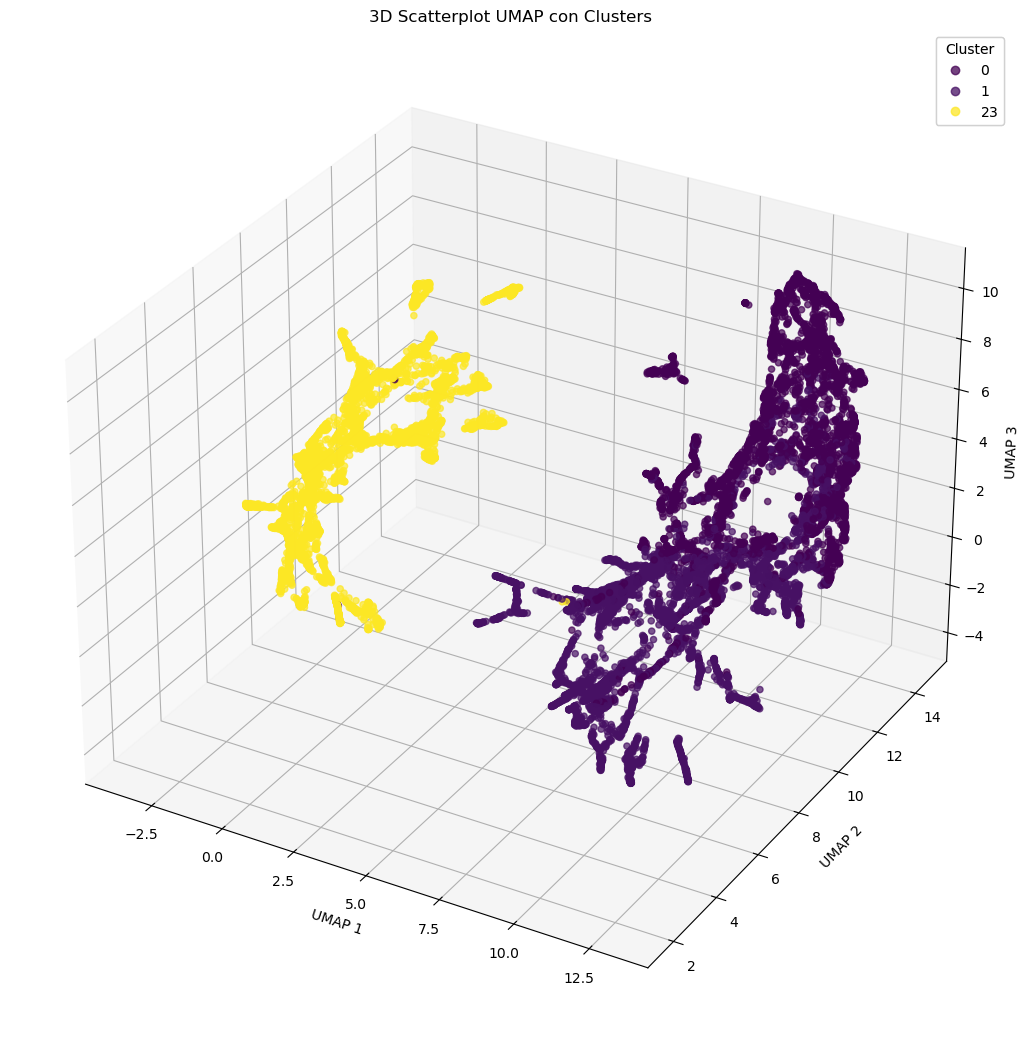

In [135]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_umap[:, 0], X_umap[:, 1], X_umap[:, 2],
    c=y_original, cmap='viridis', alpha=0.7
)

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
ax.set_title('3D Scatterplot UMAP con Clusters')

legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend1)

plt.show()

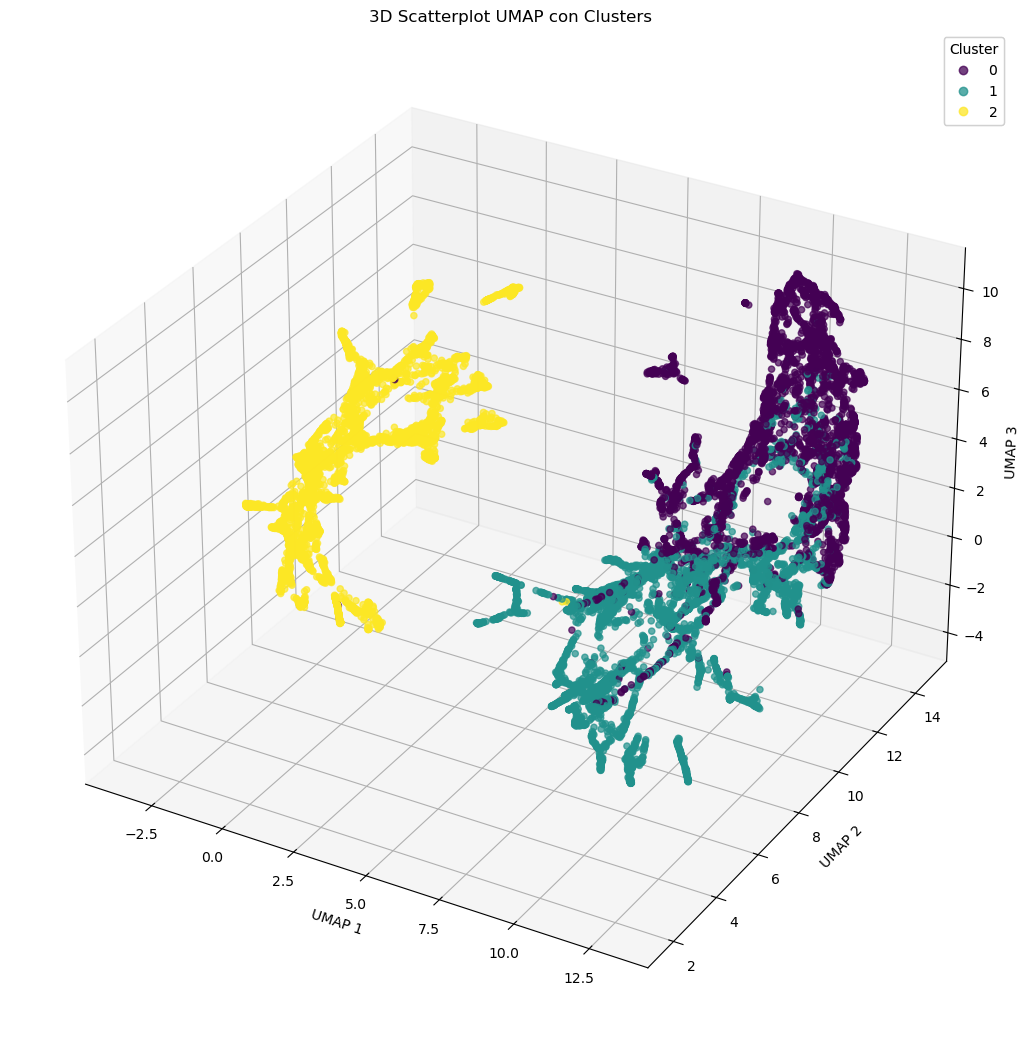

In [136]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_umap[:, 0], X_umap[:, 1], X_umap[:, 2],
    c=y, cmap='viridis', alpha=0.7
)

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
ax.set_title('3D Scatterplot UMAP con Clusters')

legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend1)

plt.show()

Ahora se procede a aplicar el Kmeans sobre los datos del espacio latente:

In [115]:
# Aplicacion de KMeans
N = 3
kmeans_umap = KMeans(n_clusters=N, random_state=42)  
labels_umap = kmeans_umap.fit_predict(X_umap)

In [116]:
unique_labels, counts = np.unique(labels_umap, return_counts=True)
print("Valores únicos en labels_umap:", unique_labels)
print("Cantidad de cada valor:", counts)

Valores únicos en labels_umap: [0 1 2]
Cantidad de cada valor: [4522 4428 4322]


In [117]:
X['cluster_umap'] = labels_umap
X['restimulus_map'] = y
X['restimulus_original'] = y_original
X.drop(columns=['restimulus'], inplace=True)
# Mostrar las primeras filas con las etiquetas de los clusters
X.head()

,RMS_ch1,RMS_ch2,RMS_ch3,RMS_ch4,RMS_ch5,RMS_ch6,RMS_ch7,RMS_ch8,RMS_ch9,RMS_ch10,cluster_umap,restimulus_map,restimulus_original
0,0.002971,0.002011,0.002235,0.002222,0.004159,0.011375,0.168135,0.424274,0.008702,0.178665,0,0,0.0
1,0.002682,0.002494,0.003043,0.002453,0.014639,0.133269,0.051355,0.055463,0.035154,0.531450,0,0,0.0
2,0.002399,0.002400,0.002487,0.002398,0.004415,0.133537,0.006214,0.002398,0.015982,0.008684,2,0,0.0
3,0.972779,0.024917,0.002912,0.002560,0.002688,0.017993,0.084669,0.466418,0.002400,0.094062,2,0,0.0
4,0.245827,0.009948,0.004982,0.003690,0.004121,0.003417,0.033055,0.097625,0.003520,0.074589,2,0,0.0


In [118]:
# Contar valores unicos del dataset original
restimulus_original_counts = y_original.value_counts()
print("Valores únicos en 'restimulus' (original):")
print(restimulus_original_counts)

# Contar valores debido al mapeo de los tags orinales
restimulus_cat_counts = y.value_counts()
print("\nValores únicos en 'restimulus_cat':")
print(restimulus_cat_counts)

# Contar valores generados por el KMeans
cluster_umap_counts = X['cluster_umap'].value_counts()
print("\nValores únicos en 'Cluster':")
print(cluster_umap_counts)

Valores únicos en 'restimulus' (original):
restimulus
0.0     4424
1.0     4424
23.0    4424
Name: count, dtype: int64

Valores únicos en 'restimulus_cat':
restimulus
0    4424
1    4424
2    4424
Name: count, dtype: int64

Valores únicos en 'Cluster':
cluster_umap
0    4522
1    4428
2    4322
Name: count, dtype: int64


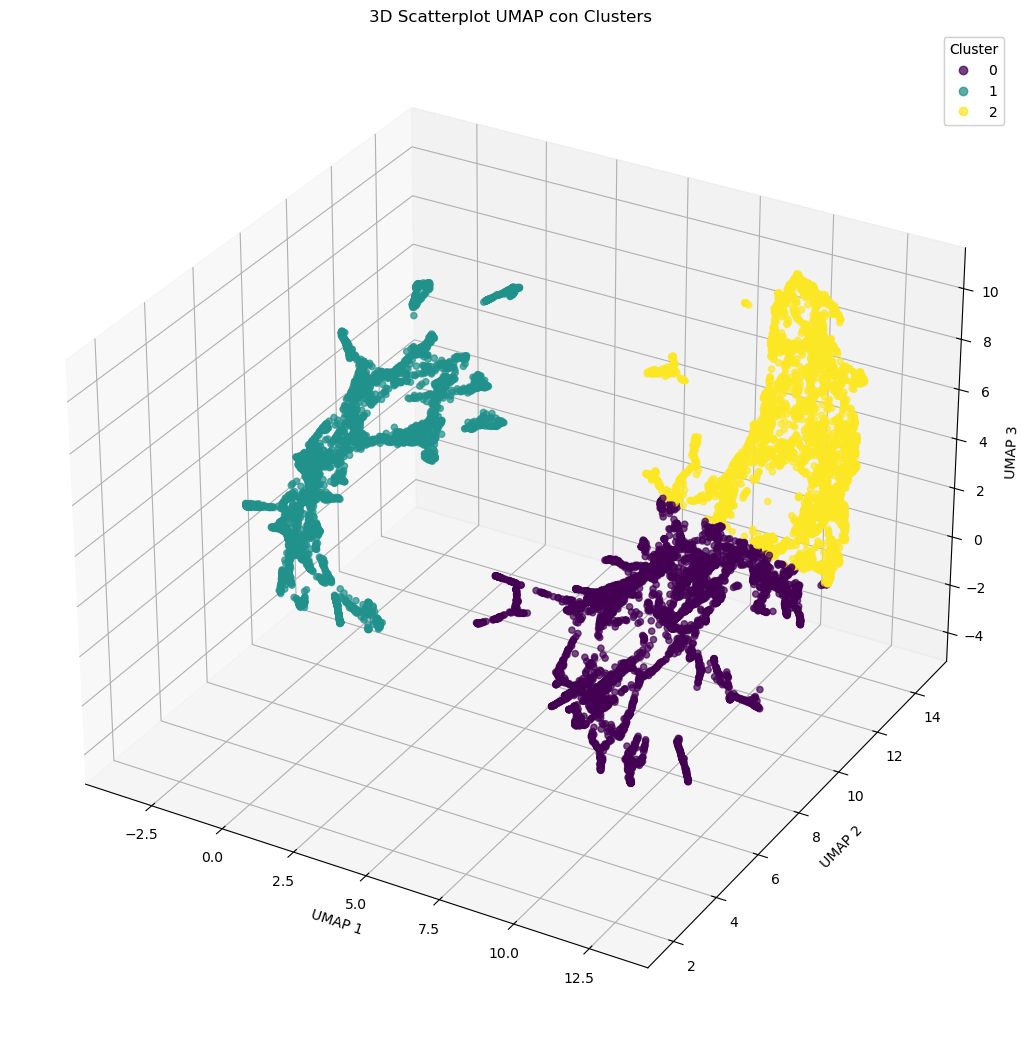

In [137]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_umap[:, 0], X_umap[:, 1], X_umap[:, 2],
    c=X['cluster_umap'], cmap='viridis', alpha=0.7
)

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
ax.set_title('3D Scatterplot UMAP con Clusters')

legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend1)

plt.show()

In [120]:
# Calcular el ARI para KMeans
ari_score_kmeans = adjusted_rand_score(X['restimulus_map'], X['cluster_umap'])

# Mostrar el resultado
print(f"Adjusted Rand Index (ARI) para KMeans: {ari_score_kmeans:.4f}")

Adjusted Rand Index (ARI) para KMeans: 0.7551


> **Conclusiones**:
>
> * El uso de UMAP antes del kmeans mejora mucho los resultados y por lo menos los hace mas descentes dando un ARI del 75%.
> * El modelo logra detectar la estructura latente real en los datos para las clases 0, 1 y 23.
> * Confusión el el taging

### 5.5. Clustering Kmeans empleando el dataset balanceado con las caracteristicas (RMS y WL)

In [210]:
for feature_name, df in dict_balanced.items():
    print(f"{feature_name}: {df.shape}")

IAV: (13272, 11)
RMS: (13272, 11)
WL: (13272, 11)


In [211]:
df_rms = dict_balanced['RMS'].copy()
df_wl = dict_balanced['WL'].copy()
df_rms.drop(columns=['restimulus'], inplace=True)
df = pd.concat([df_rms, df_wl], axis=1)
df.columns

Index(['RMS_ch1', 'RMS_ch2', 'RMS_ch3', 'RMS_ch4', 'RMS_ch5', 'RMS_ch6',
       'RMS_ch7', 'RMS_ch8', 'RMS_ch9', 'RMS_ch10', 'WL_ch1', 'WL_ch2',
       'WL_ch3', 'WL_ch4', 'WL_ch5', 'WL_ch6', 'WL_ch7', 'WL_ch8', 'WL_ch9',
       'WL_ch10', 'restimulus'],
      dtype='object')

In [212]:
conteo_por_categoria = df['restimulus'].value_counts()
print("Número de elementos por categoría en 'restimulus':")
print(conteo_por_categoria)

Número de elementos por categoría en 'restimulus':
restimulus
0.0     4424
1.0     4424
23.0    4424
Name: count, dtype: int64


In [213]:
X = df.drop(columns=['restimulus'])  # Entradas
y = df['restimulus']  # Salida
# Mostrar las dimensiones de las entradas y la salida   
print(f"Dimensiones de X (entradas): {X.shape}")
print(f"Dimensiones de y (salida): {y.shape}")

Dimensiones de X (entradas): (13272, 20)
Dimensiones de y (salida): (13272,)


In [214]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [215]:
# Aplicarion de KMeans
N = 3
kmeans = KMeans(n_clusters=N, random_state=42)
labels = kmeans.fit_predict(X_std)
unique_labels, counts = np.unique(labels, return_counts=True)
print("Valores únicos en labels_umap:", unique_labels)
print("Conteo de elementos en cada etiqueta:", counts)

Valores únicos en labels_umap: [0 1 2]
Conteo de elementos en cada etiqueta: [1405 4892 6975]


In [216]:
# Asignar las etiquetas de los clusters al conjunto de datos de entrenamiento
X['cluster'] = labels
# Contar valores únicos en las columnas 'restimulus_cat' y 'Cluster'
X['restimulus'] = y

# Mostrar las primeras filas con las etiquetas de los clusters
X.head()

,RMS_ch1,RMS_ch2,RMS_ch3,RMS_ch4,RMS_ch5,RMS_ch6,RMS_ch7,RMS_ch8,RMS_ch9,RMS_ch10,...,WL_ch3,WL_ch4,WL_ch5,WL_ch6,WL_ch7,WL_ch8,WL_ch9,WL_ch10,cluster,restimulus
0,0.002971,0.002011,0.002235,0.002222,0.004159,0.011375,0.168135,0.424274,0.008702,0.178665,...,0.001869,0.001035,0.004105,0.010771,0.037287,0.142162,0.005544,0.037949,2,0.0
1,0.002682,0.002494,0.003043,0.002453,0.014639,0.133269,0.051355,0.055463,0.035154,0.531450,...,0.000634,0.000025,0.006091,0.013155,0.001987,0.002508,0.001761,0.032935,2,0.0
2,0.002399,0.002400,0.002487,0.002398,0.004415,0.133537,0.006214,0.002398,0.015982,0.008684,...,0.000067,0.000003,0.000416,0.005391,0.001141,0.000001,0.002737,0.001122,2,0.0
3,0.972779,0.024917,0.002912,0.002560,0.002688,0.017993,0.084669,0.466418,0.002400,0.094062,...,0.000168,0.000282,0.000037,0.000780,0.002508,0.038131,0.000002,0.006464,2,0.0
4,0.245827,0.009948,0.004982,0.003690,0.004121,0.003417,0.033055,0.097625,0.003520,0.074589,...,0.000733,0.000173,0.000089,0.000077,0.007238,0.030180,0.000279,0.012079,2,0.0


In [217]:
restimulus_cat_counts = X['restimulus'].value_counts()
cluster_counts = X['cluster'].value_counts()
# Mostrar los resultados   
print("Valores únicos en 'restimulus_cat':")
print(restimulus_cat_counts)   
print("\nValores únicos en 'cluster':")
print(cluster_counts)

Valores únicos en 'restimulus_cat':
restimulus
0.0     4424
1.0     4424
23.0    4424
Name: count, dtype: int64

Valores únicos en 'cluster':
cluster
2    6975
1    4892
0    1405
Name: count, dtype: int64


In [218]:
# Calcular el ARI para KMeans
ari_score_kmeans = adjusted_rand_score(X['restimulus'], X['cluster'])

# Mostrar el resultado
print(f"Adjusted Rand Index (ARI) para KMeans: {ari_score_kmeans:.4f}")

Adjusted Rand Index (ARI) para KMeans: 0.2472


### 5.5. Clustering Kmeans + uMAP empleando el dataset balanceado con las caracteristicas (RMS y WL)

In [59]:
for feature_name, df in dict_balanced.items():
    print(f"{feature_name}: {df.shape}")

IAV: (13272, 11)
RMS: (13272, 11)
WL: (13272, 11)


In [60]:
df_rms = dict_balanced['RMS'].copy()
df_wl = dict_balanced['WL'].copy()
df_rms.drop(columns=['restimulus'], inplace=True)
df = pd.concat([df_rms, df_wl], axis=1)
df.head()

,RMS_ch1,RMS_ch2,RMS_ch3,RMS_ch4,RMS_ch5,RMS_ch6,RMS_ch7,RMS_ch8,RMS_ch9,RMS_ch10,...,WL_ch2,WL_ch3,WL_ch4,WL_ch5,WL_ch6,WL_ch7,WL_ch8,WL_ch9,WL_ch10,restimulus
0,0.002971,0.002011,0.002235,0.002222,0.004159,0.011375,0.168135,0.424274,0.008702,0.178665,...,1.626367e-03,0.001869,0.001035,0.004105,0.010771,0.037287,0.142162,0.005544,0.037949,0.0
1,0.002682,0.002494,0.003043,0.002453,0.014639,0.133269,0.051355,0.055463,0.035154,0.531450,...,1.502025e-04,0.000634,0.000025,0.006091,0.013155,0.001987,0.002508,0.001761,0.032935,0.0
2,0.002399,0.002400,0.002487,0.002398,0.004415,0.133537,0.006214,0.002398,0.015982,0.008684,...,1.533455e-07,0.000067,0.000003,0.000416,0.005391,0.001141,0.000001,0.002737,0.001122,0.0
3,0.972779,0.024917,0.002912,0.002560,0.002688,0.017993,0.084669,0.466418,0.002400,0.094062,...,3.390028e-03,0.000168,0.000282,0.000037,0.000780,0.002508,0.038131,0.000002,0.006464,0.0
4,0.245827,0.009948,0.004982,0.003690,0.004121,0.003417,0.033055,0.097625,0.003520,0.074589,...,1.827021e-03,0.000733,0.000173,0.000089,0.000077,0.007238,0.030180,0.000279,0.012079,0.0


In [61]:
df.columns

Index(['RMS_ch1', 'RMS_ch2', 'RMS_ch3', 'RMS_ch4', 'RMS_ch5', 'RMS_ch6',
       'RMS_ch7', 'RMS_ch8', 'RMS_ch9', 'RMS_ch10', 'WL_ch1', 'WL_ch2',
       'WL_ch3', 'WL_ch4', 'WL_ch5', 'WL_ch6', 'WL_ch7', 'WL_ch8', 'WL_ch9',
       'WL_ch10', 'restimulus'],
      dtype='object')

In [62]:
conteo_por_categoria = df['restimulus'].value_counts()
print("Número de elementos por categoría en 'restimulus':")
print(conteo_por_categoria)

Número de elementos por categoría en 'restimulus':
restimulus
0.0     4424
1.0     4424
23.0    4424
Name: count, dtype: int64


Separando entradas de salidas

In [132]:
X = df.drop(columns=['restimulus'])  # Entradas
y = df['restimulus']  # Salida
# Mostrar las dimensiones de las entradas y la salida   
print(f"Dimensiones de X (entradas): {X.shape}")
print(f"Dimensiones de y (salida): {y.shape}")

Dimensiones de X (entradas): (13272, 20)
Dimensiones de y (salida): (13272,)


Ahora se procede a escalar

In [133]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [ ]:
# Aplicarion de KMeans
N = 3
kmeans_umap = KMeans(n_clusters=N, random_state=42)
labels_umap = kmeans_umap.fit_predict(X_umap)
unique_labels, counts = np.unique(labels_umap, return_counts=True)
print("Valores únicos en labels_umap:", unique_labels)
print("Conteo de elementos en cada etiqueta:", counts)

Valores únicos en labels_umap: [0 1 2]
Conteo de elementos en cada etiqueta: [1535 6178 5559]


Definición de los parametros del UMAP (ajuste por malicia indigena)

In [134]:
# Aplicacion UMAP
N_NEIGHBORS = 15
MIN_DIST = 0.1
N_COMPONENTS = 3
SEED = 42
# Define UMAP model
umap_model = umap.UMAP(n_neighbors = N_NEIGHBORS,
                       min_dist = MIN_DIST,
                       n_components = N_COMPONENTS,
                       random_state = SEED)
"""
umap_model = umap.UMAP(n_components = N_COMPONENTS,
                       random_state = SEED)
"""
umap_model

UMAP(n_components=3, random_state=42)

Transdormacion de los datos usando el UMAP

In [135]:
X_umap = umap_model.fit_transform(X_std)

Ahora se procede a la segunda parte del procedimiento que consiste en realizar el clustering empleando k-means

In [136]:
# Aplicarion de KMeans
N = 3
kmeans_umap = KMeans(n_clusters=N, random_state=42)
labels_umap = kmeans_umap.fit_predict(X_umap)
unique_labels, counts = np.unique(labels_umap, return_counts=True)
print("Valores únicos en labels_umap:", unique_labels)
print("Conteo de elementos en cada etiqueta:", counts)

Valores únicos en labels_umap: [0 1 2]
Conteo de elementos en cada etiqueta: [3945 4700 4627]


In [137]:
# Asignar las etiquetas de los clusters al conjunto de datos de entrenamiento
X['cluster_umap'] = labels_umap
# Contar valores únicos en las columnas 'restimulus_cat' y 'Cluster'
X['restimulus'] = y

# Mostrar las primeras filas con las etiquetas de los clusters
X.head()

,RMS_ch1,RMS_ch2,RMS_ch3,RMS_ch4,RMS_ch5,RMS_ch6,RMS_ch7,RMS_ch8,RMS_ch9,RMS_ch10,...,WL_ch3,WL_ch4,WL_ch5,WL_ch6,WL_ch7,WL_ch8,WL_ch9,WL_ch10,cluster_umap,restimulus
0,0.002971,0.002011,0.002235,0.002222,0.004159,0.011375,0.168135,0.424274,0.008702,0.178665,...,0.001869,0.001035,0.004105,0.010771,0.037287,0.142162,0.005544,0.037949,2,0.0
1,0.002682,0.002494,0.003043,0.002453,0.014639,0.133269,0.051355,0.055463,0.035154,0.531450,...,0.000634,0.000025,0.006091,0.013155,0.001987,0.002508,0.001761,0.032935,2,0.0
2,0.002399,0.002400,0.002487,0.002398,0.004415,0.133537,0.006214,0.002398,0.015982,0.008684,...,0.000067,0.000003,0.000416,0.005391,0.001141,0.000001,0.002737,0.001122,2,0.0
3,0.972779,0.024917,0.002912,0.002560,0.002688,0.017993,0.084669,0.466418,0.002400,0.094062,...,0.000168,0.000282,0.000037,0.000780,0.002508,0.038131,0.000002,0.006464,2,0.0
4,0.245827,0.009948,0.004982,0.003690,0.004121,0.003417,0.033055,0.097625,0.003520,0.074589,...,0.000733,0.000173,0.000089,0.000077,0.007238,0.030180,0.000279,0.012079,2,0.0


In [ ]:
restimulus_cat_counts = X['restimulus'].value_counts()
cluster_umap_counts = X['cluster_umap'].value_counts()

In [139]:
# Mostrar los resultados
print("Valores únicos en 'restimulus_cat':")
print(restimulus_cat_counts)

print("\nValores únicos en 'cluster_umap':")
print(cluster_umap_counts)

Valores únicos en 'restimulus_cat':
restimulus
0.0     4424
1.0     4424
23.0    4424
Name: count, dtype: int64

Valores únicos en 'cluster_umap':
cluster_umap
1    4700
2    4627
0    3945
Name: count, dtype: int64


In [140]:
# Calcular el ARI para KMeans
ari_score_kmeans = adjusted_rand_score(X['restimulus'], X['cluster_umap'])

# Mostrar el resultado
print(f"Adjusted Rand Index (ARI) para KMeans: {ari_score_kmeans:.4f}")

Adjusted Rand Index (ARI) para KMeans: 0.4822


In [141]:
def explorar_umap_kmeans(X_scaled, y_true, vecinos=[10, 15, 30], distancias=[0.0, 0.1, 0.5]):
    resultados = []

    for n_neighbors in vecinos:
        for min_dist in distancias:
            reducer = umap.UMAP(
                n_neighbors=n_neighbors,
                min_dist=min_dist,
                n_components=2,
                metric='euclidean',
                random_state=42
            )
            X_umap = reducer.fit_transform(X_scaled)

            # KMeans con 3 clusters
            kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
            labels = kmeans.fit_predict(X_umap)

            # Evaluación
            silhouette = silhouette_score(X_umap, labels)
            ari = adjusted_rand_score(y_true, labels)

            # Guardar resultado
            resultados.append({
                "n_neighbors": n_neighbors,
                "min_dist": min_dist,
                "silhouette": silhouette,
                "ARI": ari
            })

            # Visualización
            plt.figure(figsize=(6, 4))
            sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels, palette='viridis', s=10)
            plt.title(f"UMAP: n_neighbors={n_neighbors}, min_dist={min_dist}\nSilhouette={silhouette:.2f}, ARI={ari:.2f}")
            plt.xlabel("UMAP-1")
            plt.ylabel("UMAP-2")
            plt.legend(title="Cluster")
            plt.tight_layout()
            plt.show()

    return pd.DataFrame(resultados)

Combinaciones

In [142]:
X = df.drop(columns=['restimulus'])  # Entradas
y = df['restimulus']  # Salida
# Mostrar las dimensiones de las entradas y la salida   
print(f"Dimensiones de X (entradas): {X.shape}")
print(f"Dimensiones de y (salida): {y.shape}")

# Escalado los datos
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

Dimensiones de X (entradas): (13272, 20)
Dimensiones de y (salida): (13272,)


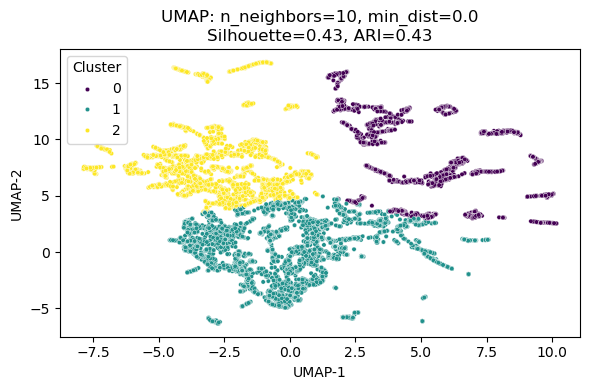

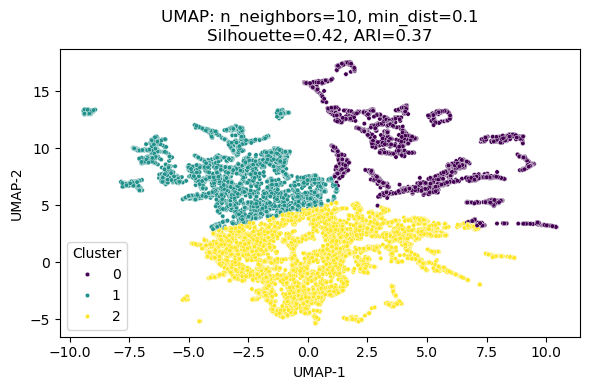

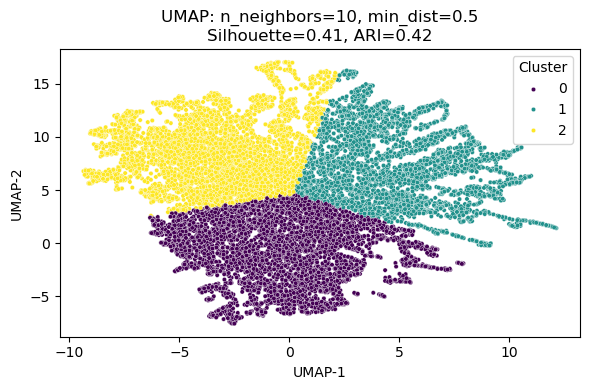

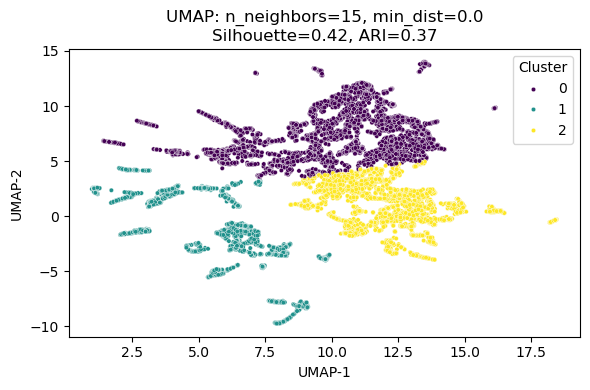

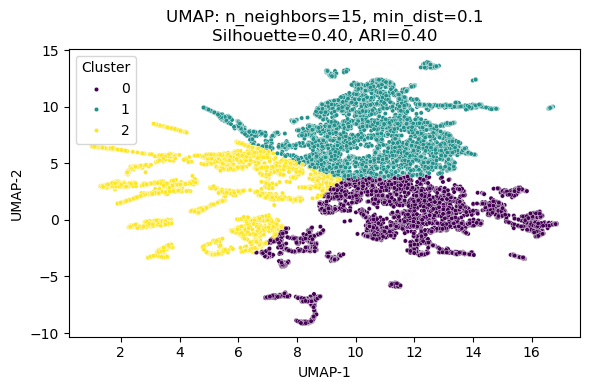

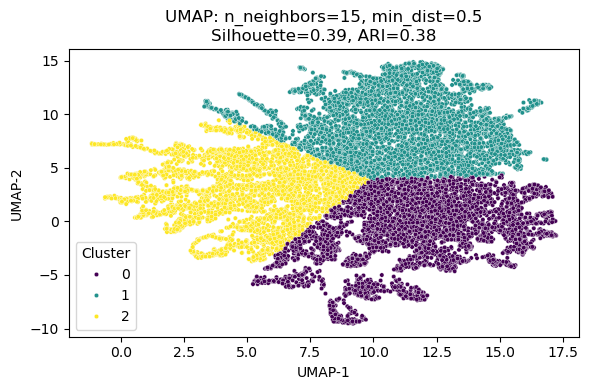

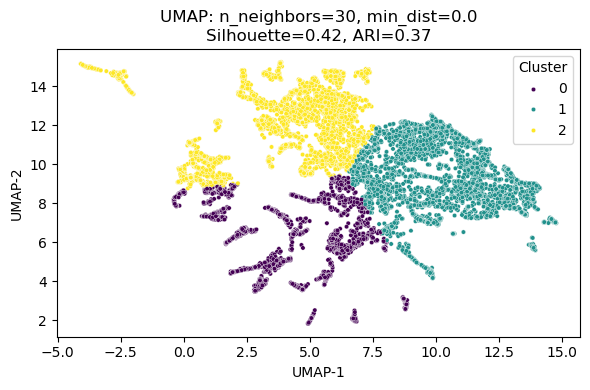

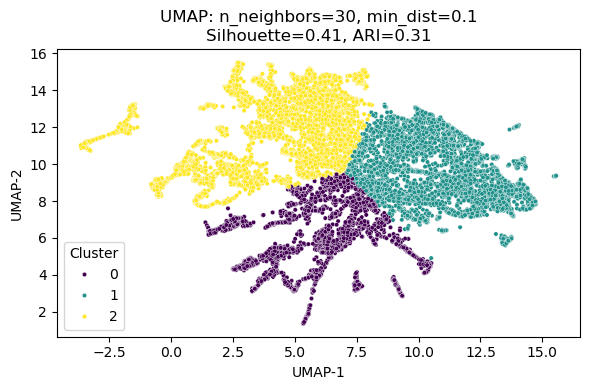

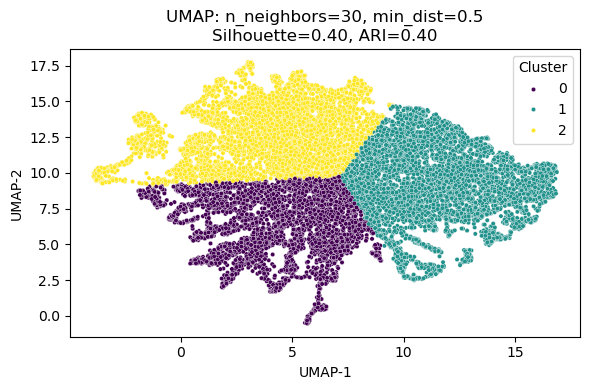

In [143]:
resultados_df = explorar_umap_kmeans(X_std, y)

> **Conclusión**:
>
> * Hasta ahora no hemos dado con la combinación ideal